In [2]:
import pandas as pd
import scanpy as sc
from scipy import io
from scipy.sparse import csr_matrix
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

os.chdir("/Users/piamozdzanowski/Documents/GitHub/PerturbCycleVI/benchmark_data")

## Test Data

In [3]:
# Load matrix
X_test = io.mmread("E-MTAB-2805.aggregated_filtered_counts.mtx").tocsr()

# Read cell and gene names
cells_test = pd.read_csv("E-MTAB-2805.aggregated_filtered_counts.mtx_rows", sep="\t", header=None)[0].values
genes_test = pd.read_csv("E-MTAB-2805.aggregated_filtered_counts.mtx_cols", sep="\t", header=None)[0].values

# Create AnnData and transpose to cells x genes
adata_test = sc.AnnData(X=X_test)
adata_test.obs_names = cells_test
adata_test.var_names = genes_test
adata_test = adata_test.T

# Save raw counts before normalization
adata_test.layers["counts"] = adata_test.X.copy()

# Load and apply cell metadata
meta_test = pd.read_csv("ExpDesign-E-MTAB-2805.tsv", sep="\t", index_col=0)
adata_test.obs = meta_test.loc[adata_test.obs_names]

# Set true_phase and harmonize label format
adata_test.obs["true_phase"] = adata_test.obs["Factor Value[cell cycle phase]"].replace({"G2/M": "G2M"})


In [4]:
print(adata_test)

AnnData object with n_obs × n_vars = 280 × 23133
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[cell line]', 'Sample Characteristic Ontology Term[cell line]', 'Sample Characteristic[cell type]', 'Sample Characteristic Ontology Term[cell type]', 'Sample Characteristic[specimen with known storage state]', 'Sample Characteristic Ontology Term[specimen with known storage state]', 'Sample Characteristic[cell cycle phase]', 'Sample Characteristic Ontology Term[cell cycle phase]', 'Factor Value[cell cycle phase]', 'Factor Value Ontology Term[cell cycle phase]', 'Factor Value[single cell identifier]', 'Factor Value Ontology Term[single cell identifier]', 'true_phase'
    layers: 'counts'


## Training Data

In [5]:
X_train = io.mmread("E-MTAB-7324.aggregated_filtered_counts.mtx").tocsr()

# Read cell and gene names
cells_train = pd.read_csv("E-MTAB-7324.aggregated_filtered_counts.mtx_rows", sep="\t", header=None)[0].values
genes_train = pd.read_csv("E-MTAB-7324.aggregated_filtered_counts.mtx_cols", sep="\t", header=None)[0].values

# Create AnnData and transpose to cells x genes
adata_train = sc.AnnData(X=X_train)
adata_train.obs_names = cells_train
adata_train.var_names = genes_train
adata_train = adata_train.T

# Save raw counts before normalization
adata_train.layers["counts"] = adata_train.X.copy()

# Load and apply cell metadata
meta_train = pd.read_csv("ExpDesign-E-MTAB-7324.tsv", sep="\t", index_col=0)
adata_train.obs = meta_train.loc[adata_train.obs_names]

In [6]:
print(adata_train)

AnnData object with n_obs × n_vars = 15927 × 21508
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[strain]', 'Sample Characteristic Ontology Term[strain]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[genotype]', 'Sample Characteristic Ontology Term[genotype]', 'Sample Characteristic[phenotype]', 'Sample Characteristic Ontology Term[phenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Factor Value[developmental stage]', 'Factor Value Ontology Term[developmental stage]', 'Factor Value[genotype]', 'Factor Value Ontology Term[genotype]'
    layer

## Cell Cycle

In [7]:
# Load gene-phase mapping (with Ensembl IDs and 'phase' column)
cell_cycle_genes = pd.read_csv("Mus_musculus.csv")

# Extract gene lists by phase
g2m_genes = cell_cycle_genes.query("phase == 'G2/M'")["geneID"].unique().tolist()
s_genes = cell_cycle_genes.query("phase == 'S'")["geneID"].unique().tolist()

# Apply scoring per AnnData object
for adata in [adata_test, adata_train]:
    adata.X = adata.layers["counts"].copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)

    matched_s = [g for g in s_genes if g in adata.var_names]
    matched_g2m = [g for g in g2m_genes if g in adata.var_names]

    print(f"Matched S genes: {len(matched_s)}, G2M genes: {len(matched_g2m)}")

    sc.tl.score_genes_cell_cycle(adata, s_genes=matched_s, g2m_genes=matched_g2m)

# Reset to raw counts after scoring
adata_test.X = adata_test.layers["counts"].copy()
adata_train.X = adata_train.layers["counts"].copy()


Matched S genes: 43, G2M genes: 54
Matched S genes: 43, G2M genes: 54


In [12]:
print(g2m_genes)

['ENSMUSG00000001403', 'ENSMUSG00000004880', 'ENSMUSG00000005698', 'ENSMUSG00000006398', 'ENSMUSG00000009575', 'ENSMUSG00000012443', 'ENSMUSG00000015749', 'ENSMUSG00000017716', 'ENSMUSG00000019942', 'ENSMUSG00000019961', 'ENSMUSG00000020330', 'ENSMUSG00000020737', 'ENSMUSG00000020808', 'ENSMUSG00000020897', 'ENSMUSG00000020914', 'ENSMUSG00000022385', 'ENSMUSG00000022391', 'ENSMUSG00000023505', 'ENSMUSG00000024056', 'ENSMUSG00000024795', 'ENSMUSG00000026605', 'ENSMUSG00000026622', 'ENSMUSG00000026683', 'ENSMUSG00000027306', 'ENSMUSG00000027379', 'ENSMUSG00000027469', 'ENSMUSG00000027496', 'ENSMUSG00000027699', 'ENSMUSG00000028044', 'ENSMUSG00000028678', 'ENSMUSG00000028873', 'ENSMUSG00000029177', 'ENSMUSG00000031004', 'ENSMUSG00000032218', 'ENSMUSG00000032254', 'ENSMUSG00000034349', 'ENSMUSG00000035293', 'ENSMUSG00000036752', 'ENSMUSG00000036777', 'ENSMUSG00000037313', 'ENSMUSG00000037544', 'ENSMUSG00000037725', 'ENSMUSG00000038252', 'ENSMUSG00000038379', 'ENSMUSG00000040549', 'ENSMUSG0

In [8]:
adata_test.obs['phase'].value_counts()

phase
G2M    120
S       91
G1      69
Name: count, dtype: int64

In [9]:
adata_test.obs['true_phase'].value_counts()

true_phase
G1     96
G2M    96
S      88
Name: count, dtype: int64

In [10]:
adata_train.obs['phase'].value_counts()

phase
S      6532
G2M    6259
G1     3136
Name: count, dtype: int64

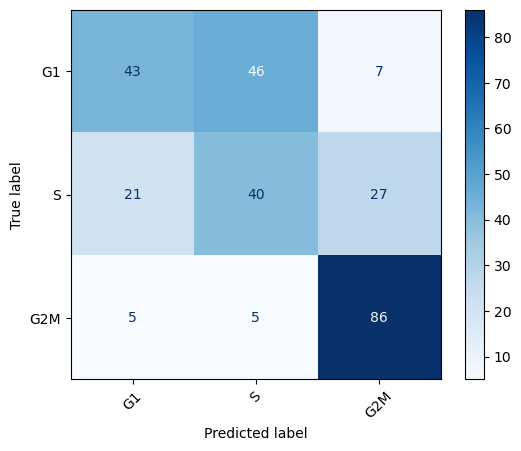

In [11]:
y_true = adata_test.obs['true_phase']
y_pred = adata_test.obs['phase']

cm = confusion_matrix(y_true, y_pred, labels=['G1', 'S', 'G2M'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['G1', 'S', 'G2M'])
disp.plot(cmap='Blues', xticks_rotation=45)

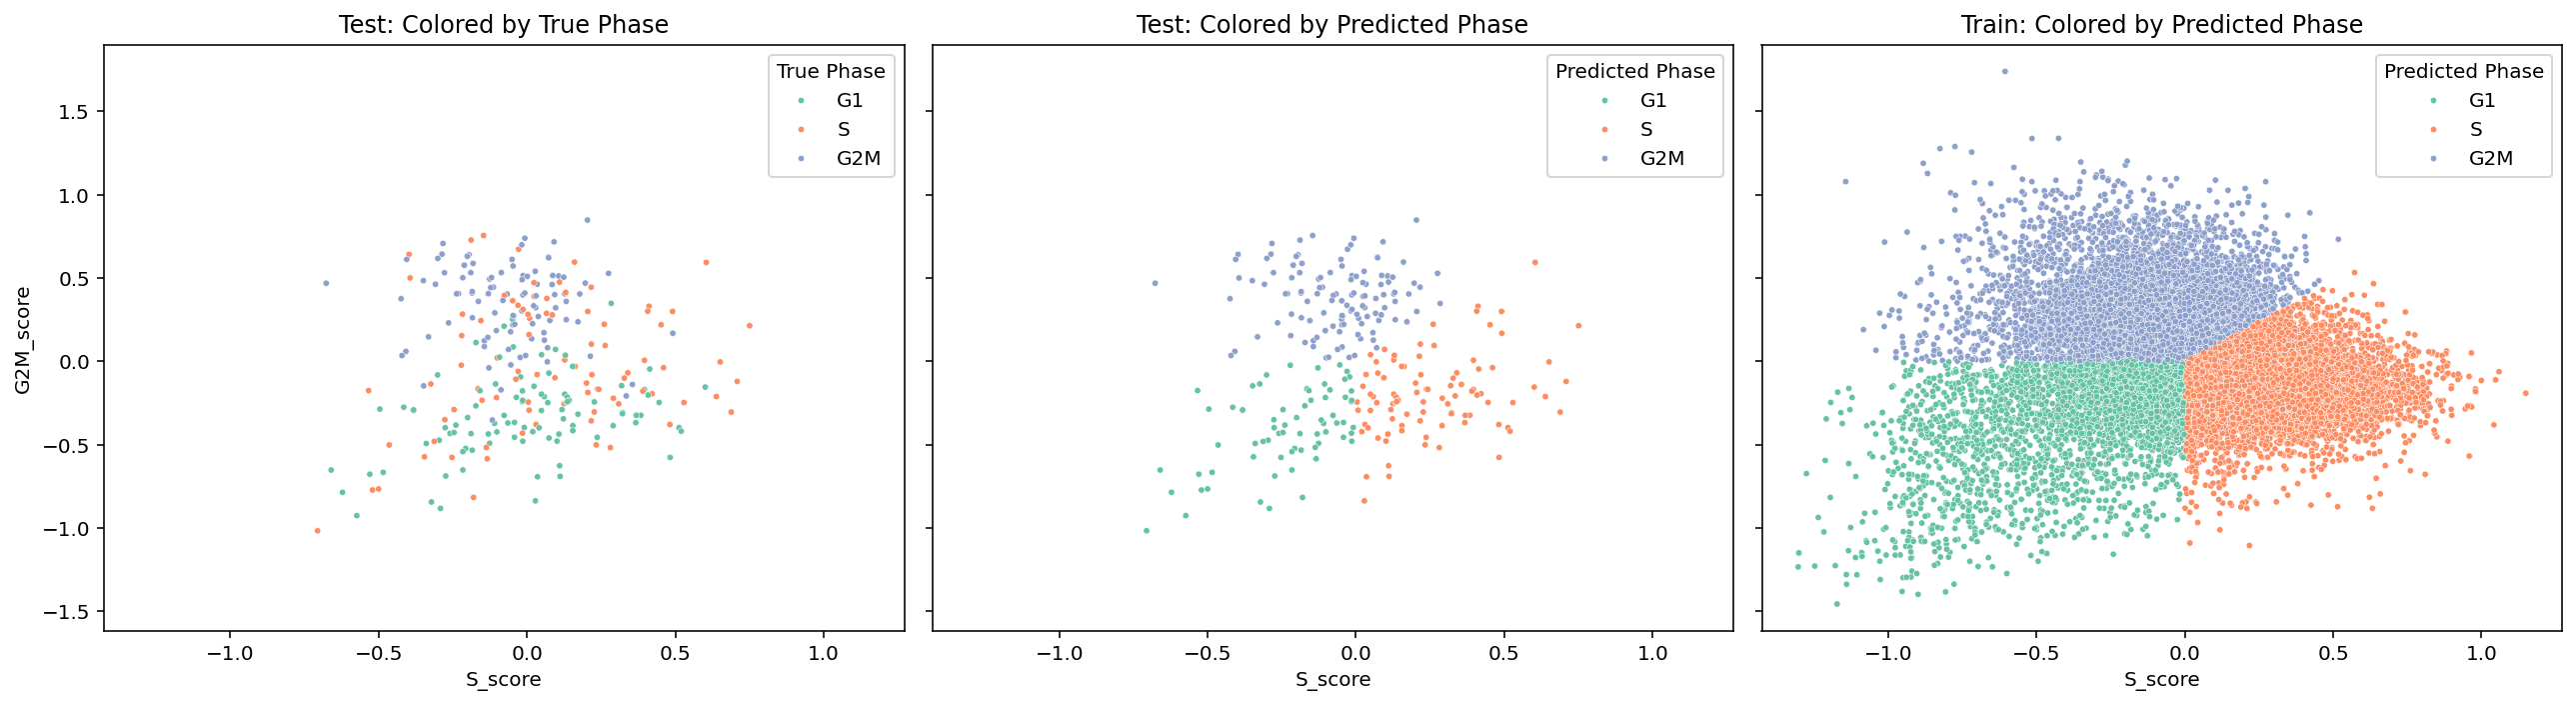

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define consistent phase categories and colors
phase_order = ['G1', 'S', 'G2M']
palette = dict(zip(phase_order, sns.color_palette('Set2', n_colors=3)))

# Create figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# Plot 1: adata_test, colored by true_phase
sns.scatterplot(
    x=adata_test.obs['S_score'],
    y=adata_test.obs['G2M_score'],
    hue=adata_test.obs['true_phase'],
    palette=palette,
    hue_order=phase_order,
    ax=axs[0],
    s=10
)
axs[0].set_title('Test: Colored by True Phase')
axs[0].set_xlabel('S_score')
axs[0].set_ylabel('G2M_score')
axs[0].legend(title='True Phase', loc='best')

# Plot 2: adata_test, colored by predicted phase
sns.scatterplot(
    x=adata_test.obs['S_score'],
    y=adata_test.obs['G2M_score'],
    hue=adata_test.obs['phase'],
    palette=palette,
    hue_order=phase_order,
    ax=axs[1],
    s=10
)
axs[1].set_title('Test: Colored by Predicted Phase')
axs[1].set_xlabel('S_score')
axs[1].set_ylabel('G2M_score')
axs[1].legend(title='Predicted Phase', loc='best')

# Plot 3: adata_train, colored by predicted phase
sns.scatterplot(
    x=adata_train.obs['S_score'],
    y=adata_train.obs['G2M_score'],
    hue=adata_train.obs['phase'],
    palette=palette,
    hue_order=phase_order,
    ax=axs[2],
    s=10
)
axs[2].set_title('Train: Colored by Predicted Phase')
axs[2].set_xlabel('S_score')
axs[2].set_ylabel('G2M_score')
axs[2].legend(title='Predicted Phase', loc='best')

plt.tight_layout()
plt.show()



## Cell Cycle Angle

In [283]:
# Function to compute angle in [0, 2π] based on S and G2M scores
def compute_cell_cycle_angle(s_score, g2m_score):
    angle = np.arctan2(g2m_score, s_score)  # angle in [-π, π]
    return (angle + 2 * np.pi) % (2 * np.pi)  # convert to [0, 2π]

# Compute for adata_test
s_scores_test = adata_test.obs["S_score"].values
g2m_scores_test = adata_test.obs["G2M_score"].values
adata_test.obs["cycle_angle"] = compute_cell_cycle_angle(s_scores_test, g2m_scores_test)

# Compute for adata_train
s_scores_train = adata_train.obs["S_score"].values
g2m_scores_train = adata_train.obs["G2M_score"].values
adata_train.obs["cycle_angle"] = compute_cell_cycle_angle(s_scores_train, g2m_scores_train)

In [284]:
from sklearn.preprocessing import QuantileTransformer
import numpy as np

def quantile_to_uniform_2pi(adata, angle_key, output_key):
    n_cells = adata.n_obs
    qt = QuantileTransformer(
        output_distribution='uniform',
        random_state=0,
        n_quantiles=n_cells,
        subsample=n_cells  # FIX: must be ≥ n_quantiles
    )
    angle_array = adata.obs[angle_key].values.reshape(-1, 1)
    angle_uniform = qt.fit_transform(angle_array).flatten()
    adata.obs[output_key] = angle_uniform * 2 * np.pi

# Apply to adata_test
quantile_to_uniform_2pi(adata_test, angle_key="cycle_angle", output_key="cycle_angle_uniform")

# Apply to adata_train
quantile_to_uniform_2pi(adata_train, angle_key="cycle_angle", output_key="cycle_angle_uniform")


/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_1931/2354936275.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 0].legend(title="Predicted Phase")
/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_1931/2354936275.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend(title="Predicted Phase")
/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_1931/2354936275.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 0].legend(title="Predicted Phase")
/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_1931/2354936275.py:63: UserWarning: No artists wit

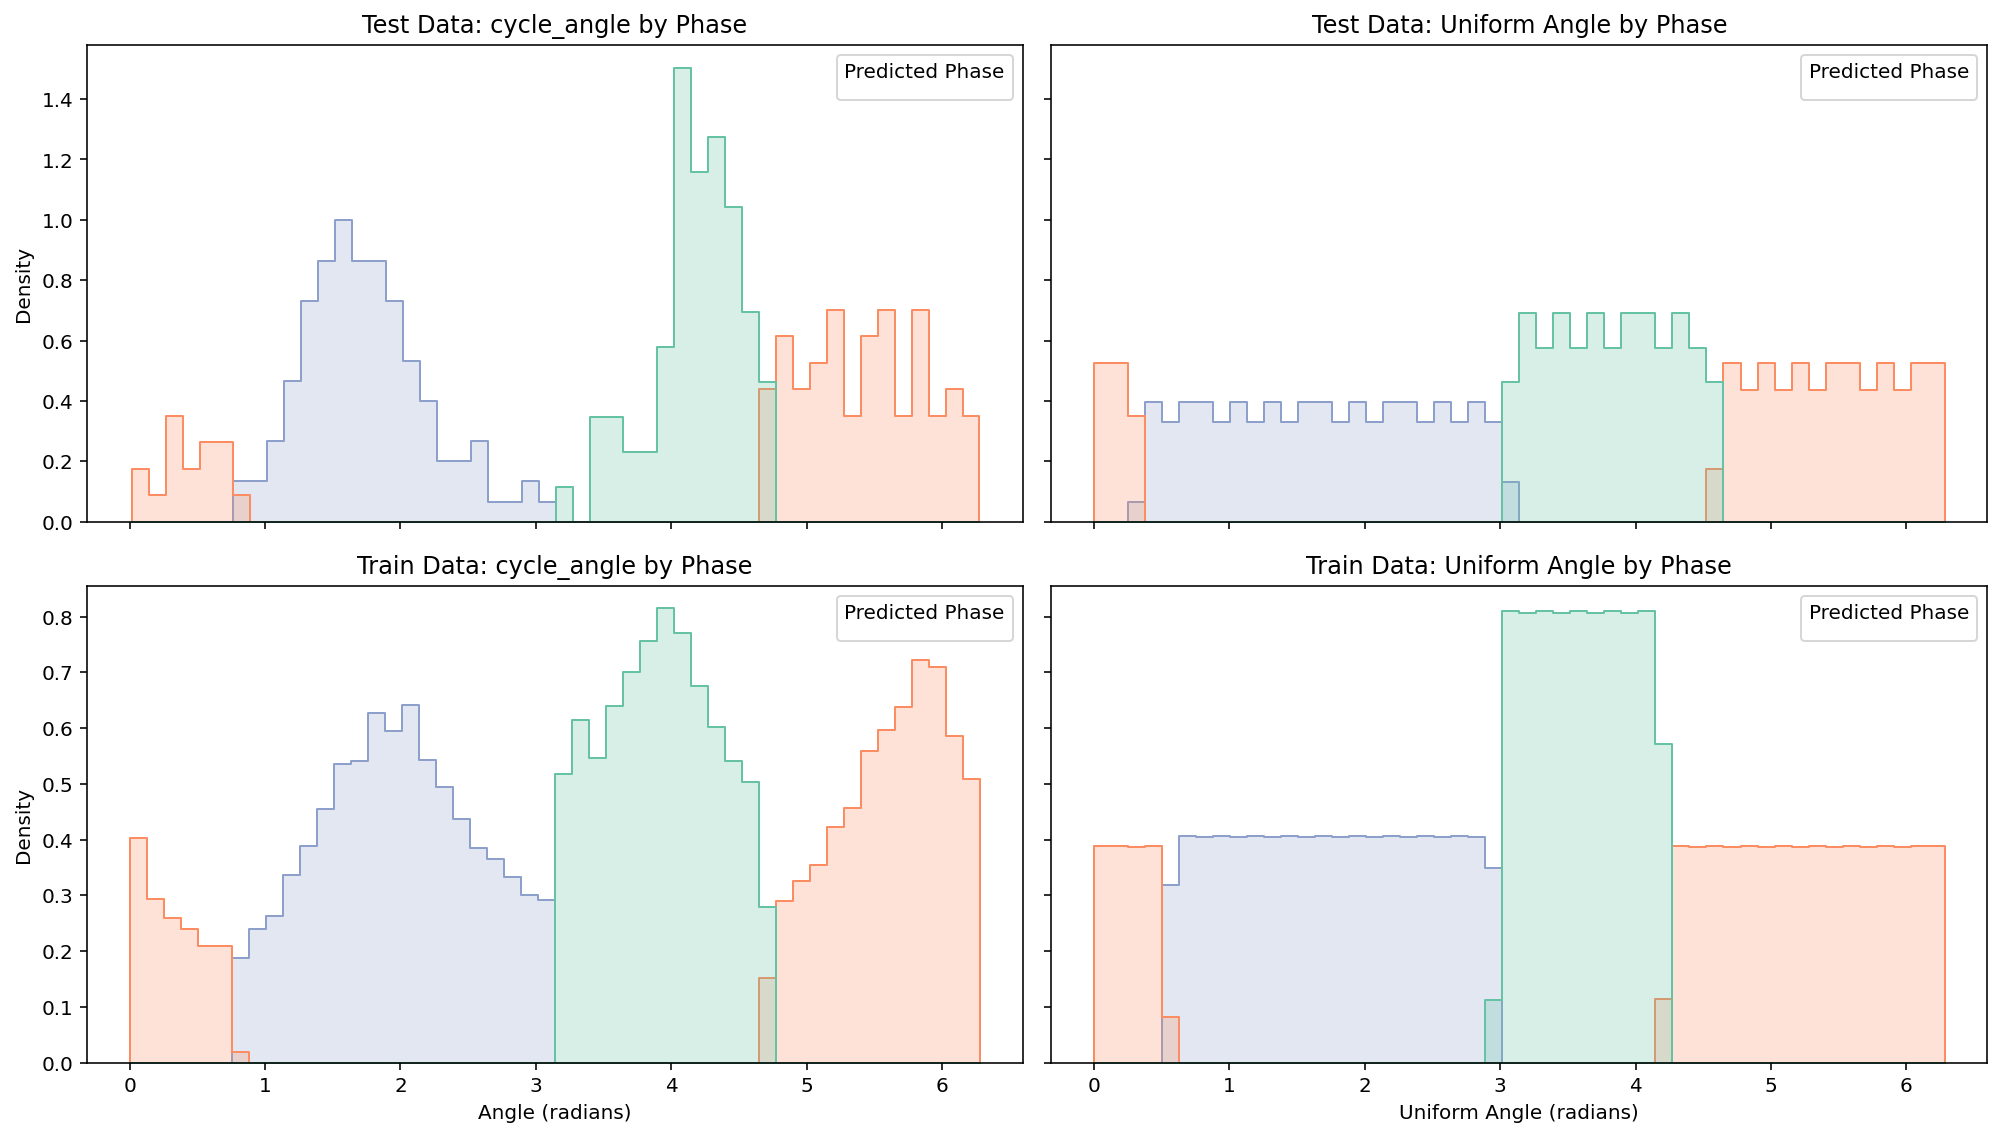

In [285]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to create a DataFrame for a given dataset
def create_cell_cycle_angle_df(adata, dataset_label):
    return pd.DataFrame({
        "cycle_angle": adata.obs["cycle_angle"],
        "cycle_angle_uniform": adata.obs["cycle_angle_uniform"],
        "predicted_phase": adata.obs["phase"],
        "dataset": dataset_label
    })

# Create dataframes
cell_cycle_df_test = create_cell_cycle_angle_df(adata_test, "test")
cell_cycle_df_train = create_cell_cycle_angle_df(adata_train, "train")

# Define phase order and color palette
phase_order = ['G1', 'S', 'G2M']
phase_palette = dict(zip(phase_order, sns.color_palette('Set2', n_colors=3)))

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex='col', sharey='row')

# Plot 1: Test cycle_angle
sns.histplot(
    data=cell_cycle_df_test, x="cycle_angle", hue="predicted_phase",
    hue_order=phase_order, palette=phase_palette, bins=50,
    ax=axes[0, 0], element='step', stat='density', common_norm=False
)
axes[0, 0].set_title("Test Data: cycle_angle by Phase")
axes[0, 0].set_xlabel("Angle (radians)")
axes[0, 0].legend(title="Predicted Phase")

# Plot 2: Test cycle_angle_uniform
sns.histplot(
    data=cell_cycle_df_test, x="cycle_angle_uniform", hue="predicted_phase",
    hue_order=phase_order, palette=phase_palette, bins=50,
    ax=axes[0, 1], element='step', stat='density', common_norm=False
)
axes[0, 1].set_title("Test Data: Uniform Angle by Phase")
axes[0, 1].set_xlabel("Uniform Angle (radians)")
axes[0, 1].legend(title="Predicted Phase")

# Plot 3: Train cycle_angle
sns.histplot(
    data=cell_cycle_df_train, x="cycle_angle", hue="predicted_phase",
    hue_order=phase_order, palette=phase_palette, bins=50,
    ax=axes[1, 0], element='step', stat='density', common_norm=False
)
axes[1, 0].set_title("Train Data: cycle_angle by Phase")
axes[1, 0].set_xlabel("Angle (radians)")
axes[1, 0].legend(title="Predicted Phase")

# Plot 4: Train cycle_angle_uniform
sns.histplot(
    data=cell_cycle_df_train, x="cycle_angle_uniform", hue="predicted_phase",
    hue_order=phase_order, palette=phase_palette, bins=50,
    ax=axes[1, 1], element='step', stat='density', common_norm=False
)
axes[1, 1].set_title("Train Data: Uniform Angle by Phase")
axes[1, 1].set_xlabel("Uniform Angle (radians)")
axes[1, 1].legend(title="Predicted Phase")

# Final layout adjustments
plt.tight_layout()
plt.show()


## Combine

In [286]:
# Step 1: Find shared genes
shared_genes = adata_test.var_names.intersection(adata_train.var_names)

# Step 2: Subset both AnnData objects to shared genes
adata_test_shared = adata_test[:, shared_genes].copy()
adata_train_shared = adata_train[:, shared_genes].copy()

# Step 3: Subsample adata_train_shared to 10,000 cells
n_subsample = 10000
if adata_train_shared.n_obs > n_subsample:
    idx = np.random.choice(adata_train_shared.n_obs, n_subsample, replace=False)
    adata_train_shared = adata_train_shared[idx]

# Step 4: Concatenate datasets
adata_combined = adata_test_shared.concatenate(
    adata_train_shared,
    batch_key="dataset",
    batch_categories=["test", "train"],
    index_unique=None
)

n_shared_genes = len(shared_genes)
print(f"Number of shared genes: {n_shared_genes}")


/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_1931/3210817501.py:15: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_test_shared.concatenate(


Number of shared genes: 19447


## Exploration

In [287]:
# Step 1: Filter low-quality genes and cells
sc.pp.filter_cells(adata_combined, min_genes=200)
sc.pp.filter_genes(adata_combined, min_cells=3)

# Step 2: Normalize and log-transform .X (leave .layers["counts"] untouched)
sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)

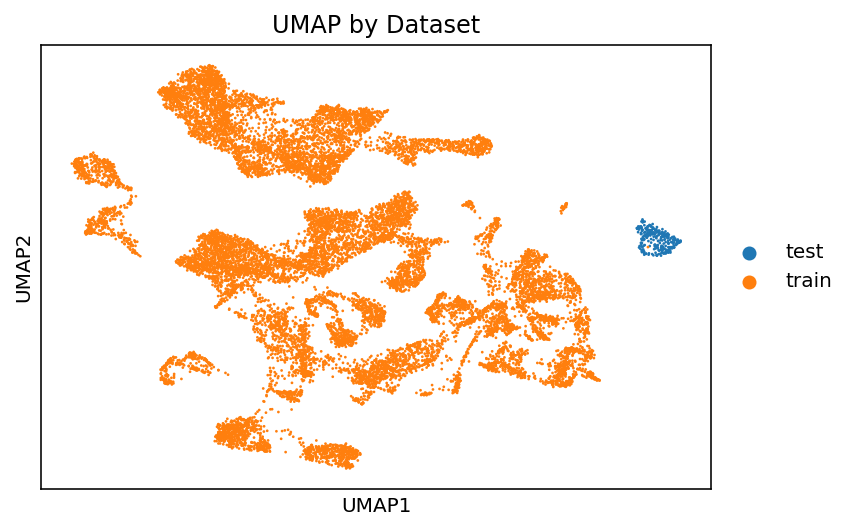

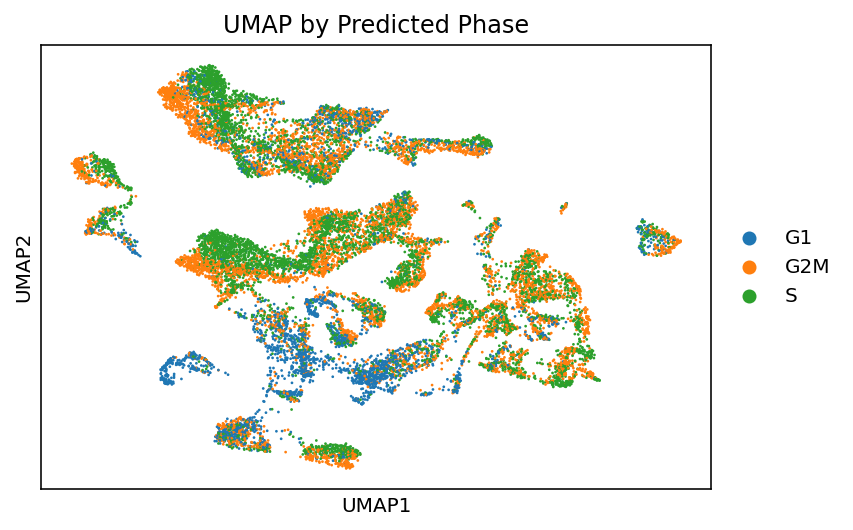

In [264]:
# Step 3: Compute UMAP
sc.pp.scale(adata_combined)
sc.tl.pca(adata_combined, svd_solver='arpack')
sc.pp.neighbors(adata_combined)
sc.tl.umap(adata_combined)

# Plot a) by dataset, b) by phase
sc.pl.umap(adata_combined, color="dataset", title="UMAP by Dataset")
sc.pl.umap(adata_combined, color="phase", title="UMAP by Predicted Phase")

In [288]:
# Step 4: Save to file
adata_combined.write("mESC_benchmark.h5ad")

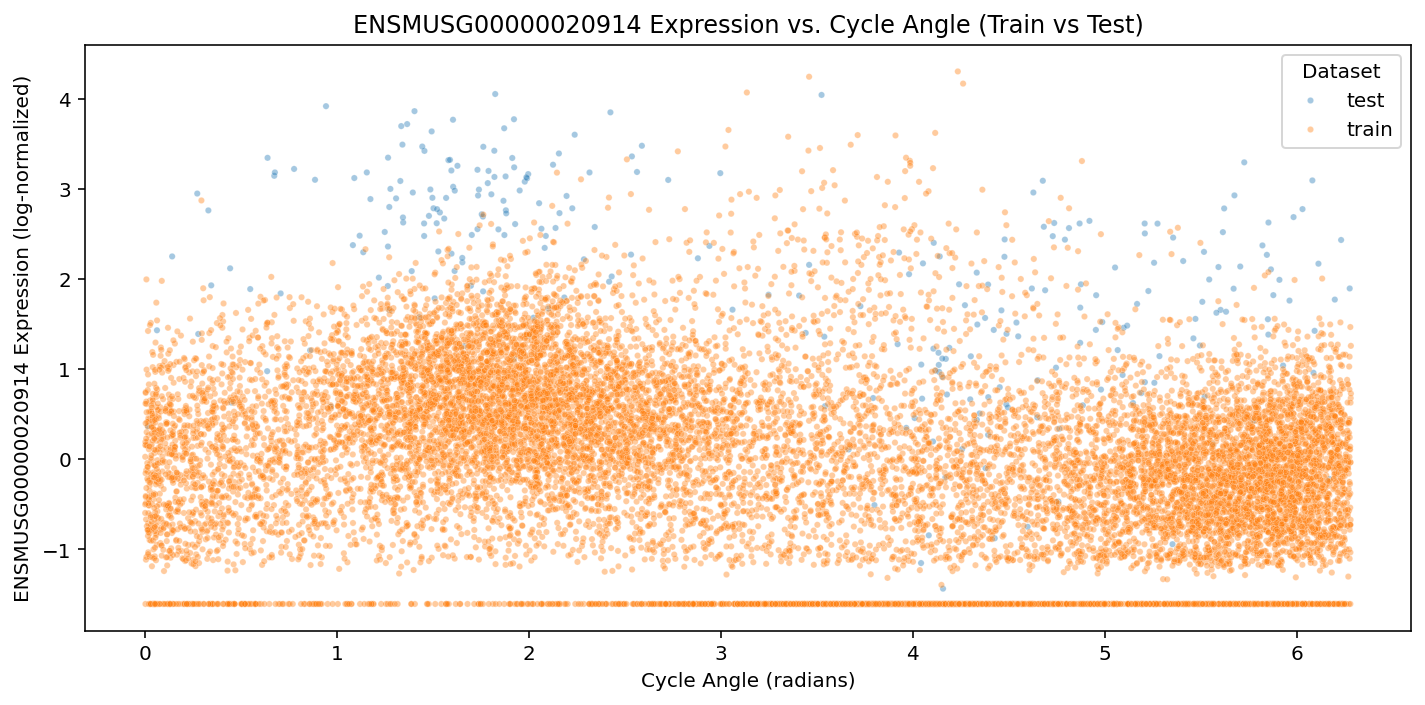

In [271]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

gene_id = "ENSMUSG00000020914"  # TOP2A

# Check that gene exists
if gene_id not in adata_combined.var_names:
    raise ValueError(f"{gene_id} not found in adata_combined.var_names")

# Extract normalized expression values
expr = adata_combined[:, gene_id].X
expr = expr.A1 if sparse.issparse(expr) else expr.flatten()

# Assemble DataFrame
df_expr_angle = pd.DataFrame({
    "expression": expr,
    "cycle_angle": adata_combined.obs["cycle_angle"],
    "dataset": adata_combined.obs["dataset"]
})

# Plot: expression vs angle
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_expr_angle, x="cycle_angle", y="expression", hue="dataset", alpha=0.4, s=10)
plt.xlabel("Cycle Angle (radians)")
plt.ylabel(f"{gene_id} Expression (log-normalized)")
plt.title(f"{gene_id} Expression vs. Cycle Angle (Train vs Test)")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
from mygene import MyGeneInfo

# Load file
df = pd.read_csv("GO_term_summary_20250527_102603.txt", sep="\t", dtype=str)

# Extract unique gene symbols
symbols = df["Symbol"].dropna().unique().tolist()

# Query mygene.info to convert to Ensembl Gene IDs (mouse)
mg = MyGeneInfo()
res = mg.querymany(
    symbols,
    scopes="symbol",
    fields="ensembl.gene",
    species="mouse"
)

# Extract Ensembl gene IDs
ensembl_ids = []
for r in res:
    if 'ensembl' in r:
        ids = r['ensembl']
        if isinstance(ids, list):
            ensembl_ids.extend([i['gene'] for i in ids if 'gene' in i])
        elif isinstance(ids, dict) and 'gene' in ids:
            ensembl_ids.append(ids['gene'])

# Deduplicate and sort
ensembl_ids = sorted(set(ensembl_ids))

# Save to text file
with open("mouse_cell_cycle_ensembl.txt", "w") as f:
    for gene_id in ensembl_ids:
        f.write(gene_id + "\n")

print(f"Saved {len(ensembl_ids)} mouse Ensembl IDs to mouse_cell_cycle_ensembl.txt")


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1486 input query terms found no hit:	['RIKEN cDNA 1700009N14 gene', 'RIKEN cDNA 1700013H16 gene', 'RIKEN cDNA 1700028K03 gene', 'RIKEN cD


Saved 0 mouse Ensembl IDs to mouse_cell_cycle_ensembl.txt


In [10]:
with open("GO_term_summary_20250527_102603.txt") as f:
    for _ in range(5):
        print(f.readline())


MGI Gene/Marker ID	Symbol	Name	Chr	Qualifier	Annotated Term	Context	Proteoform	Evidence	Inferred From	Reference(s)

MGI:1922721	1700009N14Rik	RIKEN cDNA 1700009N14 gene	4		mitotic sister chromatid segregation			ISO	P62826 	J:164563 	

MGI:1922764	1700013H16Rik	RIKEN cDNA 1700013H16 gene	X		meiotic cell cycle			IBA	MGI:109542 PTN001064565 	J:161428 	

MGI:1923671	1700028K03Rik	RIKEN cDNA 1700028K03 gene	5		reciprocal meiotic recombination			IBA	MGI:1923671 PTN001584519 	J:161428 	

MGI:1923671	1700028K03Rik	RIKEN cDNA 1700028K03 gene	5		synaptonemal complex assembly			IBA	MGI:1923671 PTN001584519 	J:161428 	



In [12]:
import re
from mygene import MyGeneInfo

# Load file and extract gene symbols (2nd column)
symbols = set()
with open("GO_term_summary_20250527_102603.txt") as f:
    for line in f:
        if line.strip() == "" or line.startswith("MGI Gene/Marker ID"):
            continue  # Skip header or empty lines
        parts = re.split(r"\s+", line.strip())
        if len(parts) >= 2:
            symbols.add(parts[1])

symbols = sorted(symbols)

# Query mygene to convert symbols to Ensembl gene IDs
mg = MyGeneInfo()
res = mg.querymany(
    symbols,
    scopes="symbol",
    fields="ensembl.gene",
    species="mouse"
)

# Extract Ensembl IDs
ensembl_ids = []
for r in res:
    if 'ensembl' in r and not r.get('notfound', False):
        ids = r['ensembl']
        if isinstance(ids, list):
            ensembl_ids.extend([i['gene'] for i in ids if 'gene' in i])
        elif isinstance(ids, dict):
            ensembl_ids.append(ids.get('gene'))

# Deduplicate and sort
ensembl_ids = sorted(set(filter(None, ensembl_ids)))

# Save to txt file
with open("mouse_cell_cycle_ensembl.txt", "w") as f:
    for gene_id in ensembl_ids:
        f.write(gene_id + "\n")

print(f"✅ Saved {len(ensembl_ids)} mouse Ensembl IDs to mouse_cell_cycle_ensembl.txt")


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
20 input query terms found dup hits:	[('Anapc15-ps', 2), ('Bend2', 2), ('Gm20817', 2), ('Gm20820', 2), ('Gm21095', 2), ('Gm21294', 2), ('
2 input query terms found no hit:	['Gm10332', 'Mir1186']


✅ Saved 1487 mouse Ensembl IDs to mouse_cell_cycle_ensembl.txt
